# Common Task 
## description
Classify the images into three classes strong lensing images with no substructure, subhalo substructure, and vortex substructure.

## Introduction

This project demonstrates how to apply the [Semantic Clustering by Adopting Nearest neighbors
(SCAN)](https://arxiv.org/abs/2005.12320) algorithm (Van Gansbeke et al., 2020) on the
Strong Lens dataset. The algorithm consists of
two phases:

1. Self-supervised visual representation learning of images, in which we use the
[simCLR](https://arxiv.org/abs/2002.05709) technique.
2. Clustering of the learned visual representation vectors to maximize the agreement
between the cluster assignments of neighboring vectors.



In [1]:
## Introduction
!pip install tensorflow-addons
!pip install tensorflow
!pip install tqdm
!pip install sklearn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 33.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tfx-bsl 1.12.0 requires google-api-python-client<2,>=1.7.11, but you have google-api-python-client 2.82.0 which is incompatible.
onnx 1.13.1 requires protobuf<4,>=3.20.2, but you have protobuf 3.19.6 which is incompatible.
apache-beam 2.44.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.6 which is incompatible.
  Preparing metadata (setup.py) ... - done
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=399ecacd070675b6f8a1460e7be1c8ecc7290908f0caaf22657df851b0447d6f
  Stored in directory: /root/.cache/pip/wheels/15/9a/b1/2478e73

## Setup

In [2]:

from collections import defaultdict
import random
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

## Prepare the data

In [3]:
num_classes = 3
input_shape = (150, 150, 3)

# !wget https://mhjhvfvskrssnpi.studio.us-east-2.sagemaker.aws/studiolab/default/jupyter/lab/tree/ML4S/data_task
x_data=[]
for f in os.listdir('/kaggle/input/common-test/data_task/lens_data/'):
    x_data.append(np.load('/kaggle/input/common-test/data_task/lens_data/'+f, allow_pickle=True))


classes = [
    "1",
    "2",
    "3",
]

In [4]:
x_train_dup=[]
x_test_dup=[]

seen=set()
for i in range(5000):
    ran_idx=np.random.choice(range(20000))
    x_train_dup.append(np.transpose([x_data[ran_idx][0], x_data[ran_idx][0], x_data[ran_idx][0]]))
for i in range(2000):
    ran_idx=np.random.choice(range(20000))
    x_test_dup.append(np.transpose([x_data[ran_idx][0], x_data[ran_idx][0], x_data[ran_idx][0]]))

x_data=[] #space saving 
seen=set() #space saving 
x_train=np.array(x_train_dup)
x_test=np.array(x_test_dup)
print(x_train.shape, x_test.shape)

(5000, 150, 150, 3) (2000, 150, 150, 3)


## Define hyperparameters

In [5]:
target_size = 128  # Resize the input images.
representation_dim = 512  # The dimensions of the features vector.
projection_units = 128  # The projection head of the representation learner.
num_clusters = 3  # Number of clusters.
k_neighbours = 3  # Number of neighbours to consider during cluster learning.
tune_encoder_during_clustering = False  # Freeze the encoder in the cluster learning.

## Implement data preprocessing

The data preprocessing step resizes the input images to the desired `target_size` and applies
feature-wise normalization. Note that, when using `keras.applications.ResNet50V2` as the
visual encoder, resizing the images into 255 x 255 inputs would lead to more accurate results
but require a longer time to train.

In [6]:
data_preprocessing = keras.Sequential(
    [
        layers.Resizing(target_size, target_size),
        layers.Normalization(),
    ]
)
# Compute the mean and the variance from the data for normalization.
# data_preprocessing.layers[-1].adapt(x_train[0]).shape

## Data augmentation

Unlike simCLR, which randomly picks a single data augmentation function to apply to an input
image, we apply a set of data augmentation functions randomly to the input image.
(You can experiment with other image augmentation techniques by following
the [data augmentation tutorial](https://www.tensorflow.org/tutorials/images/data_augmentation).)

In [7]:
data_augmentation = keras.Sequential(
    [
        layers.RandomTranslation(
            height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode="nearest"
        ),
        layers.RandomFlip(mode="horizontal"),
        layers.RandomRotation(factor=0.15, fill_mode="nearest"),
        layers.RandomZoom(
            height_factor=(-0.3, 0.1), width_factor=(-0.3, 0.1), fill_mode="nearest"
        ),
    ]
)

Display a random image

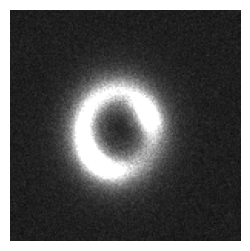

In [8]:
image_idx = np.random.choice(range(x_train.shape[0]))
image = x_train[image_idx]
# image_class = classes[y_data[image_idx][0]]
plt.figure(figsize=(3, 3))
plt.imshow(x_train[image_idx])
# plt.title(image_class)
_ = plt.axis("off")

Display a sample of augmented versions of the image

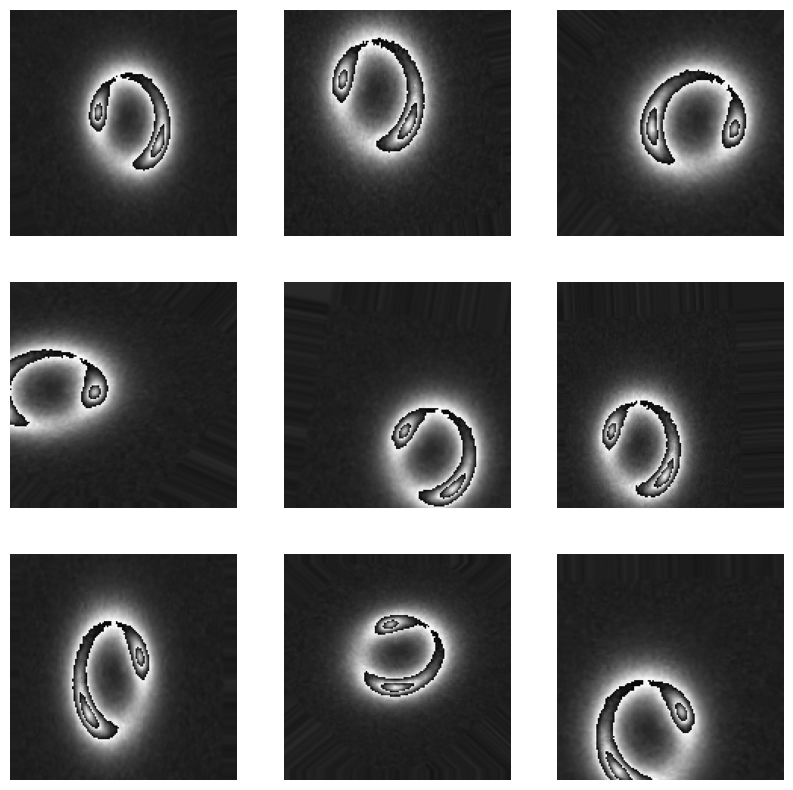

In [9]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_images = data_augmentation(np.array([image]))
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Self-supervised representation learning

### Implement the vision encoder

In [10]:

def create_encoder(representation_dim):
    encoder = keras.Sequential(
        [
            keras.applications.ResNet50V2(
                include_top=False, weights=None, pooling="avg"
            ),
            layers.Dense(representation_dim),
        ]
    )
    return encoder


### Implement the unsupervised contrastive loss

In [11]:

class RepresentationLearner(keras.Model):
    def __init__(
        self,
        encoder,
        projection_units,
        num_augmentations,
        temperature=1.0,
        dropout_rate=0.1,
        l2_normalize=False,
        **kwargs
    ):
        super().__init__(**kwargs)
        self.encoder = encoder
        # Create projection head.
        self.projector = keras.Sequential(
            [
                layers.Dropout(dropout_rate),
                layers.Dense(units=projection_units, use_bias=False),
                layers.BatchNormalization(),
                layers.ReLU(),
            ]
        )
        self.num_augmentations = num_augmentations
        self.temperature = temperature
        self.l2_normalize = l2_normalize
        self.loss_tracker = keras.metrics.Mean(name="loss")

    @property
    def metrics(self):
        return [self.loss_tracker]

    def compute_contrastive_loss(self, feature_vectors, batch_size):
        num_augmentations = tf.shape(feature_vectors)[0] // batch_size
        if self.l2_normalize:
            feature_vectors = tf.math.l2_normalize(feature_vectors, -1)
        # The logits shape is [num_augmentations * batch_size, num_augmentations * batch_size].
        logits = (
            tf.linalg.matmul(feature_vectors, feature_vectors, transpose_b=True)
            / self.temperature
        )
        # Apply log-max trick for numerical stability.
        logits_max = tf.math.reduce_max(logits, axis=1)
        logits = logits - logits_max
        # The shape of targets is [num_augmentations * batch_size, num_augmentations * batch_size].
        # targets is a matrix consits of num_augmentations submatrices of shape [batch_size * batch_size].
        # Each [batch_size * batch_size] submatrix is an identity matrix (diagonal entries are ones).
        targets = tf.tile(tf.eye(batch_size), [num_augmentations, num_augmentations])
        # Compute cross entropy loss
        return keras.losses.categorical_crossentropy(
            y_true=targets, y_pred=logits, from_logits=True
        )

    def call(self, inputs):
        # Preprocess the input images.
        preprocessed = data_preprocessing(inputs)
        # Create augmented versions of the images.
        augmented = []
        for _ in range(self.num_augmentations):
            augmented.append(data_augmentation(preprocessed))
        augmented = layers.Concatenate(axis=0)(augmented)
        # Generate embedding representations of the images.
        features = self.encoder(augmented)
        # Apply projection head.
        return self.projector(features)

    def train_step(self, inputs):
        batch_size = tf.shape(inputs)[0]
        # Run the forward pass and compute the contrastive loss
        with tf.GradientTape() as tape:
            feature_vectors = self(inputs, training=True)
            loss = self.compute_contrastive_loss(feature_vectors, batch_size)
        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update loss tracker metric
        self.loss_tracker.update_state(loss)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, inputs):
        batch_size = tf.shape(inputs)[0]
        feature_vectors = self(inputs, training=False)
        loss = self.compute_contrastive_loss(feature_vectors, batch_size)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}


### Train the model

In [12]:
# Create vision encoder.
encoder = create_encoder(representation_dim)
# Create representation learner.
representation_learner = RepresentationLearner(
    encoder, projection_units, num_augmentations=2, temperature=0.1
)
# Create a a Cosine decay learning rate scheduler.
lr_scheduler = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.001, decay_steps=10, alpha=0.1
)
# Compile the model.
representation_learner.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=lr_scheduler, weight_decay=0.0001),
)

checkpoint_path='checkpoints/'
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*100)



# representation_learner.load_weights('/kaggle/input/common-test/checkpoints/')
# loading saved checkpoint
if os.path.exists('checkpoints/'):
    history=representation_learner.fit(x_train, batch_size=100, epochs=1)
else:
    # Fit the model.
    history = representation_learner.fit(
        x=x_train,
        batch_size=100,
        epochs=10,
        callbacks=[cp_callback],
        # for better results, increase the number of epochs to 500.
    )


Epoch 1/10
50/50 [==============================] - 1072s 21s/step - loss: 119.5762
Epoch 2/10
50/50 [==============================] - 1050s 21s/step - loss: 18.9664
Epoch 3/10
50/50 [==============================] - 1047s 21s/step - loss: 11.1188
Epoch 4/10
50/50 [==============================] - 1046s 21s/step - loss: 9.1347
Epoch 5/10
50/50 [==============================] - 1064s 21s/step - loss: 8.7542
Epoch 6/10
50/50 [==============================] - 1016s 20s/step - loss: 8.2638
Epoch 7/10
50/50 [==============================] - 1006s 20s/step - loss: 8.2643
Epoch 8/10
50/50 [==============================] - 1000s 20s/step - loss: 7.9131
Epoch 9/10
50/50 [==============================] - 989s 20s/step - loss: 7.6427
Epoch 10/10
49/50 [============================>.] - ETA: 19s - loss: 7.4660
Epoch 10: saving model to checkpoints/
50/50 [==============================] - 995s 20s/step - loss: 7.4626


Plot training loss

In [13]:
representation_learner.save_weights('checkpoints/')

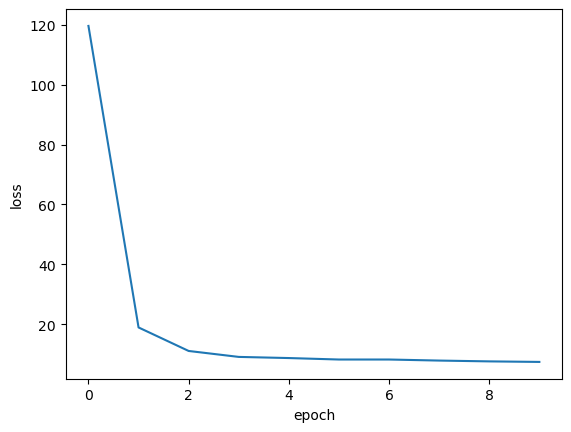

In [14]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()


## Compute the nearest neighbors

### Generate the embeddings for the images

In [15]:
batch_size = 100
# Get the feature vector representations of the images.
feature_vectors = encoder.predict(x_train, batch_size=batch_size, verbose=1)
# Normalize the feature vectores.
feature_vectors = tf.math.l2_normalize(feature_vectors, -1)

50/50 [==============================] - 128s 3s/step


### Find the *k* nearest neighbours for each embedding

In [16]:
neighbours = []
num_batches = feature_vectors.shape[0] // batch_size
for batch_idx in tqdm(range(num_batches)):
    start_idx = batch_idx * batch_size
    end_idx = start_idx + batch_size
    current_batch = feature_vectors[start_idx:end_idx]
    # Compute the dot similarity.
    similarities = tf.linalg.matmul(current_batch, feature_vectors, transpose_b=True)
    # Get the indices of most similar vectors.
    _, indices = tf.math.top_k(similarities, k=k_neighbours + 1, sorted=True)
    # Add the indices to the neighbours.
    neighbours.append(indices[..., 1:])

neighbours = np.reshape(np.array(neighbours), (-1, k_neighbours))

100%|██████████| 50/50 [00:00<00:00, 120.28it/s]


Let's display some neighbors on each row

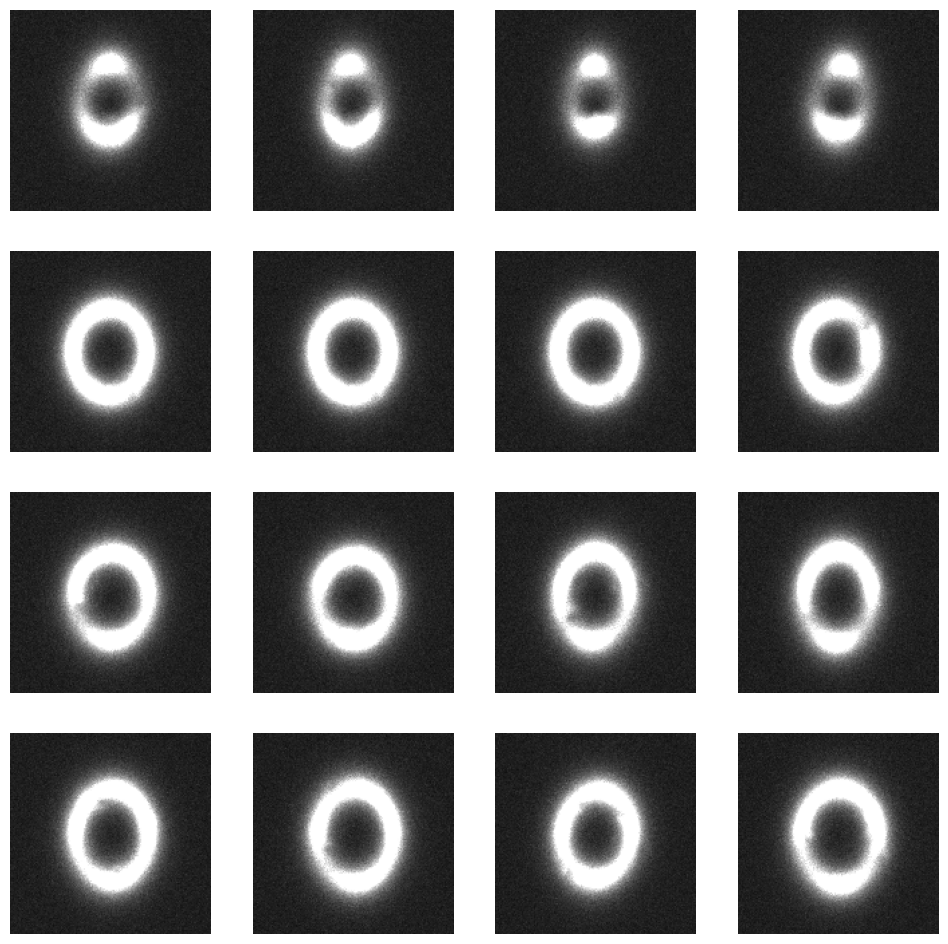

In [17]:
nrows = 4
ncols = k_neighbours + 1

plt.figure(figsize=(12, 12))
position = 1
for _ in range(nrows):
    anchor_idx = np.random.choice(range(x_train.shape[0]))
    neighbour_indicies = neighbours[anchor_idx]
    indices = [anchor_idx] + neighbour_indicies.tolist()
    for j in range(ncols):
        plt.subplot(nrows, ncols, position)
        plt.imshow(x_train[indices[j]])
        # plt.title(classes[[indices[j]][0]])
        plt.axis("off")
        position += 1

You notice that images on each row are visually similar, and belong to similar classes.

## Semantic clustering with nearest neighbours

### Implement clustering consistency loss

This loss tries to make sure that neighbours have the same clustering assignments.

In [18]:

class ClustersConsistencyLoss(keras.losses.Loss):
    def __init__(self):
        super().__init__()

    def __call__(self, target, similarity, sample_weight=None):
        # Set targets to be ones.
        target = tf.ones_like(similarity)
        # Compute cross entropy loss.
        loss = keras.losses.binary_crossentropy(
            y_true=target, y_pred=similarity, from_logits=True
        )
        return tf.math.reduce_mean(loss)


### Implement the clusters entropy loss

This loss tries to make sure that cluster distribution is roughly uniformed, to avoid
assigning most of the instances to one cluster.

In [19]:

class ClustersEntropyLoss(keras.losses.Loss):
    def __init__(self, entropy_loss_weight=1.0):
        super().__init__()
        self.entropy_loss_weight = entropy_loss_weight

    def __call__(self, target, cluster_probabilities, sample_weight=None):
        # Ideal entropy = log(num_clusters).
        num_clusters = tf.cast(tf.shape(cluster_probabilities)[-1], tf.dtypes.float32)
        target = tf.math.log(num_clusters)
        # Compute the overall clusters distribution.
        cluster_probabilities = tf.math.reduce_mean(cluster_probabilities, axis=0)
        # Replacing zero probabilities - if any - with a very small value.
        cluster_probabilities = tf.clip_by_value(
            cluster_probabilities, clip_value_min=1e-8, clip_value_max=1.0
        )
        # Compute the entropy over the clusters.
        entropy = -tf.math.reduce_sum(
            cluster_probabilities * tf.math.log(cluster_probabilities)
        )
        # Compute the difference between the target and the actual.
        loss = target - entropy
        return loss


### Implement clustering model

This model takes a raw image as an input, generated its feature vector using the trained
encoder, and produces a probability distribution of the clusters given the feature vector
as the cluster assignments.

In [20]:

def create_clustering_model(encoder, num_clusters, name=None):
    inputs = keras.Input(shape=input_shape)
    # Preprocess the input images.
    preprocessed = data_preprocessing(inputs)
    # Apply data augmentation to the images.
    augmented = data_augmentation(preprocessed)
    # Generate embedding representations of the images.
    features = encoder(augmented)
    # Assign the images to clusters.
    outputs = layers.Dense(units=num_clusters, activation="softmax")(features)
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=outputs, name=name)
    return model


### Implement clustering learner

This model receives the input `anchor` image and its `neighbours`, produces the clusters
assignments for them using the `clustering_model`, and produces two outputs:
1. `similarity`: the similarity between the cluster assignments of the `anchor` image and
its `neighbours`. This output is fed to the `ClustersConsistencyLoss`.
2. `anchor_clustering`: cluster assignments of the `anchor` images. This is fed to the `ClustersEntropyLoss`.

In [21]:

def create_clustering_learner(clustering_model):
    anchor = keras.Input(shape=input_shape, name="anchors")
    neighbours = keras.Input(
        shape=tuple([k_neighbours]) + input_shape, name="neighbours"
    )
    # Changes neighbours shape to [batch_size * k_neighbours, width, height, channels]
    neighbours_reshaped = tf.reshape(neighbours, shape=tuple([-1]) + input_shape)
    # anchor_clustering shape: [batch_size, num_clusters]
    anchor_clustering = clustering_model(anchor)
    # neighbours_clustering shape: [batch_size * k_neighbours, num_clusters]
    neighbours_clustering = clustering_model(neighbours_reshaped)
    # Convert neighbours_clustering shape to [batch_size, k_neighbours, num_clusters]
    neighbours_clustering = tf.reshape(
        neighbours_clustering,
        shape=(-1, k_neighbours, tf.shape(neighbours_clustering)[-1]),
    )
    # similarity shape: [batch_size, 1, k_neighbours]
    similarity = tf.linalg.einsum(
        "bij,bkj->bik", tf.expand_dims(anchor_clustering, axis=1), neighbours_clustering
    )
    # similarity shape:  [batch_size, k_neighbours]
    similarity = layers.Lambda(lambda x: tf.squeeze(x, axis=1), name="similarity")(
        similarity
    )
    # Create the model.
    model = keras.Model(
        inputs=[anchor, neighbours],
        outputs=[similarity, anchor_clustering],
        name="clustering_learner",
    )
    return model


### Train model (Finetuning)

In [22]:
resizing = keras.Sequential(
    [
        layers.CenterCrop(target_size, target_size),
    ]
)

# plt.imshow(x_train[0])
# print(x_train[0])
# print(resizing(x_train[0]))
# print(data_preprocessing.layers[-1].adapt(x_train[0]))
# plt.imshow(r)
# plt.imshow(np.resize(x_train[0], (120, 120, 3)))
# print(img_sample.shape)
# plt.imshow(img_sample)
# Compute the mean and the variance from the data for normalization.
# x_train=data_preprocessing(x_train)

In [23]:
# If tune_encoder_during_clustering is set to False,
# then freeze the encoder weights.
for layer in encoder.layers:
    layer.trainable = tune_encoder_during_clustering
# Create the clustering model and learner.
clustering_model = create_clustering_model(encoder, num_clusters, name="clustering")
clustering_learner = create_clustering_learner(clustering_model)
# Instantiate the model losses.
losses = [ClustersConsistencyLoss(), ClustersEntropyLoss(entropy_loss_weight=5)]
# Create the model inputs and labels.
inputs = {"anchors":x_train , "neighbours": tf.gather(x_train, neighbours)}
labels = tf.ones(shape=(x_train.shape[0]))
# Compile the model.
clustering_learner.compile(
    optimizer=tfa.optimizers.AdamW(learning_rate=0.0005, weight_decay=0.0001),
    loss=losses,
)


# Begin training the model.
clustering_learner.fit(x=inputs, y=labels, batch_size=100, epochs=10)

Epoch 1/10
50/50 [==============================] - 381s 7s/step - loss: 0.5318 - similarity_loss: 0.5280 - clustering_loss: 0.0038
Epoch 2/10
50/50 [==============================] - 366s 7s/step - loss: 0.5126 - similarity_loss: 0.5099 - clustering_loss: 0.0027
Epoch 3/10
50/50 [==============================] - 366s 7s/step - loss: 0.5017 - similarity_loss: 0.4996 - clustering_loss: 0.0021
Epoch 4/10
50/50 [==============================] - 367s 7s/step - loss: 0.4941 - similarity_loss: 0.4914 - clustering_loss: 0.0027
Epoch 5/10
50/50 [==============================] - 367s 7s/step - loss: 0.4880 - similarity_loss: 0.4849 - clustering_loss: 0.0031
Epoch 6/10
50/50 [==============================] - 369s 7s/step - loss: 0.4826 - similarity_loss: 0.4800 - clustering_loss: 0.0026
Epoch 7/10
50/50 [==============================] - 379s 8s/step - loss: 0.4800 - similarity_loss: 0.4763 - clustering_loss: 0.0037
Epoch 8/10
50/50 [==============================] - 373s 7s/step - loss: 0.4

Plot training loss

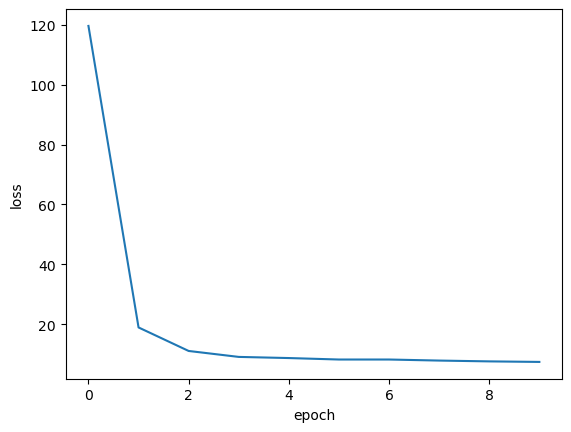

In [24]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

## Cluster analysis

### Assign images to clusters

In [25]:
# Get the cluster probability distribution of the input images.
clustering_probs = clustering_model.predict(x_train, batch_size=batch_size, verbose=1)
# Get the cluster of the highest probability.
cluster_assignments = tf.math.argmax(clustering_probs, axis=-1).numpy()
# Store the clustering confidence.
# Images with the highest clustering confidence are considered the 'prototypes'
# of the clusters.
cluster_confidence = tf.math.reduce_max(clustering_probs, axis=-1).numpy()

50/50 [==============================] - 86s 2s/step


Let's compute the cluster sizes

In [26]:
clusters = defaultdict(list)
for idx, c in enumerate(cluster_assignments):
    clusters[c].append((idx, cluster_confidence[idx]))

for c in range(num_clusters):
    print("cluster", c, ":", len(clusters[c]))

cluster 0 : 1049
cluster 1 : 1866
cluster 2 : 2085


Notice that the clusters have roughly balanced sizes.

### Visualize cluster images

Display the *prototypes*—instances with the highest clustering confidence—of each cluster: I have taken 4 images from each cluster

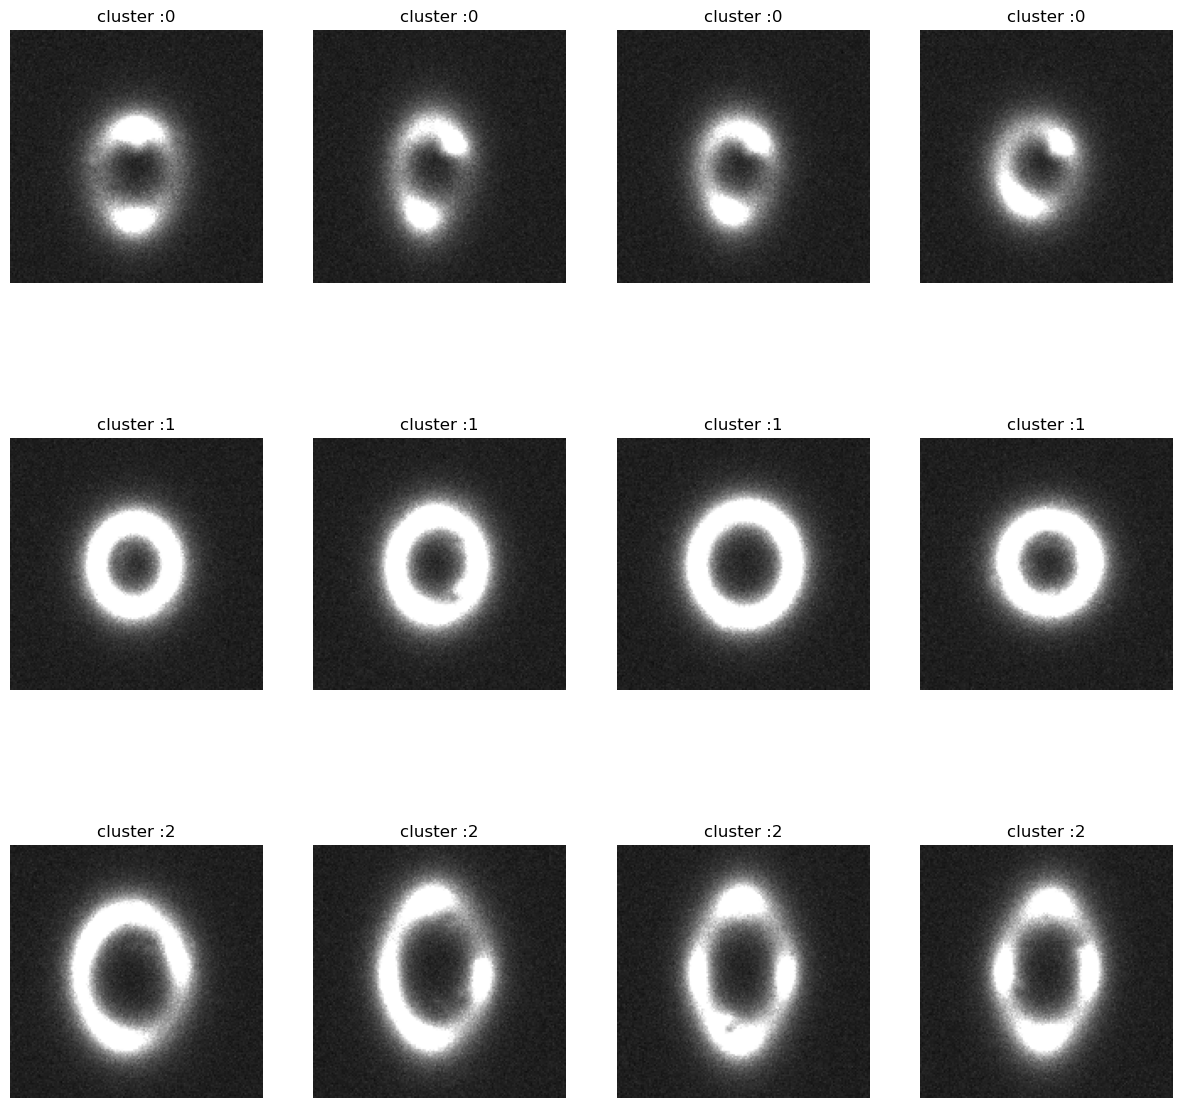

In [27]:
num_images = 4
plt.figure(figsize=(15, 15))
position = 1
for c in range(num_clusters):
    cluster_instances = sorted(clusters[c], key=lambda kv: kv[1], reverse=True)
    for j in range(num_images):
        image_idx = cluster_instances[j][0]
        plt.subplot(num_clusters, num_images, position)
        plt.imshow(x_train[image_idx])
        plt.title('cluster :'+str(c))
        plt.axis("off")
        position += 1

### Compute clustering accuracy

First we get the images which are already assigned to a culster, we augment the images and feed it to model to pridict the label. Based on the results ROC Curve has been plotted.

In [28]:
data=[]
#30 samples are taken from each cluster due to resource constraints
for i in range(3):
    for j in range(30):
        data.append([clusters[i][j], i])
tp=1
fp=1
tn=1
fn=1

data_points_x=[]
data_points_y=[]

def get_tpr(tp, fn):
    return tp/(tp+fn)

def get_fpr(fp, tn):
    return fp/(fp+tn)

#true_labels
#Pridicted_labels
t_l=[]
p_l=[]

for i in range(len(data)):
    #Augmeting the image and giving it as input to predict, we alredy know the label of image augmented
    clustering_probs = clustering_model.predict(np.array([data_augmentation(x_train[data[i][0][0]])]), verbose=1)
    cluster_assignments = tf.math.argmax(clustering_probs, axis=-1).numpy()
    t_l.append(data[i][1])
    p_l.append(cluster_assignments)
    if cluster_assignments==0:
        tp+=1
    elif (cluster_assignments==2 or cluster_assignments==1) and (data[i][1]==2 or data[i][1]==1):
        tn+=1
    elif (cluster_assignments==0) and (data[i][1]==2 or data[i][1]==1):
        fp+=1
    else:
        fn+=1
        
    data_points_y.append(get_tpr(tp, fn))
    data_points_x.append(get_fpr(fp, tn))

1/1 [==============================] - 0s 58ms/step


In [29]:
!pip install scikit-learn
from sklearn import metrics

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:1023: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.asarray(y)


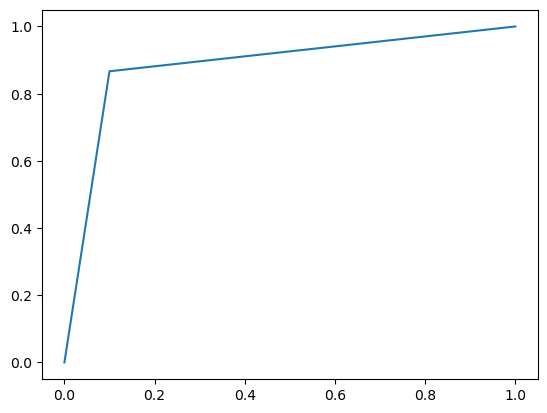

In [30]:
#Binarizing the class labels (meaning:cluster 0 is assigned 0 and cluster 1, 2 are assigned 1, so that it is convienent to plot ROC cruve)
for i in range(len(t_l)):
    if t_l[i]!=0:
        t_l[i]=1
    if p_l[i]!=0:
        p_l[i]=1
fr, tr, _= metrics.roc_curve(t_l, p_l)
plt.plot(fr, tr)